# CorrelAid X Challenge 2021 - Classifying tensions in social media data using NLP
Chapter Bremen X HH

### Libraries

In [1]:
!pip3 install transformers
import tensorflow as tf
import tensorflow_datasets as tfds

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from collections import Counter

from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 34.0 MB/s 
     |████████████████████████████████| 596 kB 42.5 MB/s 
     |████████████████████████████████| 3.3 MB 38.4 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [27]:
"""Defining model parameters"""
DECISION_THRESHOLD = 0.1  # Threshold for class label probabilities
LR = 2e-5 # Keep it small when transfer learning e.g. 2e-5 (?)
EPOCHS = 6  # 6..20 ?
seed_batching = 123
BATCH_SIZE = 32

Threshold=0.01 50 steps/epoch 2e-5 LR -> model exploded (Loss grown above 1) macro-f1 = 0.030

Tesla K80  5591–8736 	1864–2912  GFLOPS

Tesla P100 9519–10609 	4760–5304

Tesla T4    8100 / ???


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Oct 28 17:31:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Data set
## 1.1. Get data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_raw = pd.read_csv("./drive/My Drive/Bert/phoenix_tensions.csv")
df_appendix = pd.read_csv("./drive/My Drive/Bert/phoenix_tensions_appendix.csv")

In [ ]:
#df_raw = pd.read_csv("phoenix_tensions.csv")
#df_appendix = pd.read_csv("phoenix_tensions_appendix.csv")

In [ ]:
COL_ORDER = df_raw.filter(like="is_").columns

## 1.2. Preprocessing

In [ ]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              1644 non-null   int64  
 1   object_id                               1644 non-null   object 
 2   object_type                             1644 non-null   object 
 3   text                                    1644 non-null   object 
 4   is_economic_labour_tension              1644 non-null   float64
 5   economic_labour_tension_direction       128 non-null    object 
 6   is_political_tension                    1644 non-null   float64
 7   political_tension_direction             159 non-null    object 
 8   is_service_related_tension              1644 non-null   float64
 9   service_related_tension_direction       134 non-null    object 
 10  is_community_insecurity_tension         1644 non-null   floa

In [ ]:
#Recode tensions as they have different categories 

tensions = [
    "economic_labour_tension_direction",
    "political_tension_direction",
    "service_related_tension_direction",
    "community_insecurity_tension_direction",
]

print("old categories\n")

for i in tensions:
    print(i)
    print(Counter(df_raw[i]))

print("\nnew categories\n")    

#define Categorical dtype for Tensions
cat_type = CategoricalDtype(categories=["decrease", "neutral", "increase"], ordered=True)

#recode tensions 
for i in tensions:
    df[i] = df[i].replace([' '], [np.nan])
    df[i] = df[i].replace(['Neutral', 'Neural', 'Nautral'], 'neutral')
    df[i] = df[i].replace(['Increase', 'ncrease'], 'increase')
    df[i] = df[i].replace(['Decrease'], 'decrease')
    df[i] = df[i].astype(cat_type) #make defined categorical dtype

    print(i)
    print(Counter(df[i]))

old categories

economic_labour_tension_direction
Counter({nan: 1516, 'Increase': 63, 'Neutral': 38, 'neutral': 18, 'increase': 6, 'decrease': 1, 'ncrease': 1, 'Nautral': 1})
political_tension_direction
Counter({nan: 1485, 'Increase': 85, 'Neutral': 47, 'neutral': 26, 'increase': 1})
service_related_tension_direction
Counter({nan: 1510, 'Increase': 64, 'Neutral': 37, 'neutral': 17, 'Decrease': 8, 'increase': 5, 'decrease': 2, ' ': 1})
community_insecurity_tension_direction
Counter({nan: 1596, 'Neutral': 27, 'Increase': 14, 'neutral': 5, 'increase': 1, 'Neural': 1})

new categories

economic_labour_tension_direction
Counter({nan: 1516, 'increase': 70, 'neutral': 57, 'decrease': 1})
political_tension_direction
Counter({nan: 1485, 'increase': 86, 'neutral': 73})
service_related_tension_direction
Counter({nan: 1511, 'increase': 69, 'neutral': 54, 'decrease': 10})
community_insecurity_tension_direction
Counter({nan: 1596, 'neutral': 33, 'increase': 15})


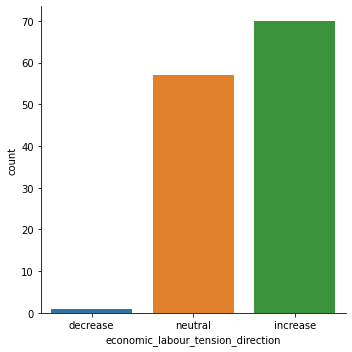

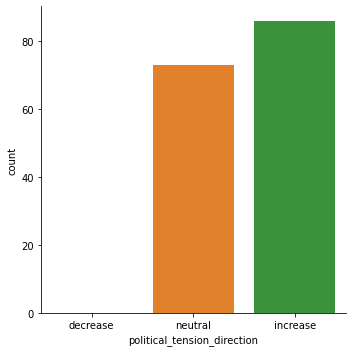

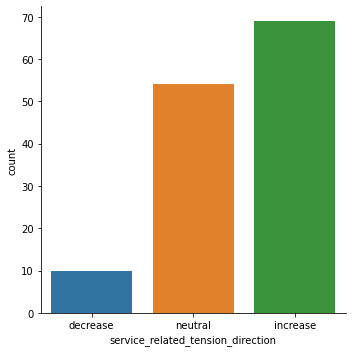

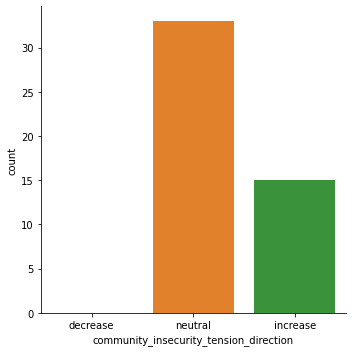

In [ ]:
#Plot Tensions
for i in tensions:
    sns.catplot(x=i, kind="count", data=df)

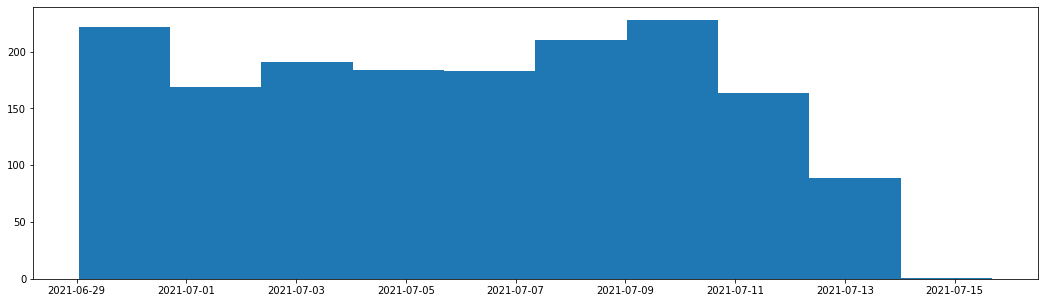

In [ ]:
#Recode date to date format
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d %H:%M:%S')

#has 3 NA values (NaT)

#plot date
fig, ax = plt.subplots(figsize = (18, 5))
plt.hist(df["date"])
plt.show()

## 1.3. Dummies & Train_Test_Split

In [ ]:
#Make dummies
#Na values will simply get 0 

df = pd.get_dummies(df, columns=["economic_labour_tension_direction", "political_tension_direction",
                            "service_related_tension_direction","community_insecurity_tension_direction"],
                          drop_first=False
              )

#Drop neutral dummies to only keep increase/ decrease
df = df[df.columns.drop(list(df.filter(regex='neutral')))]

In [ ]:
#Train and Test Split 

train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=2021, 
)

In [ ]:
train_df.to_csv("dummy_train.csv")
test_df.to_csv("dummy_test.csv")

In [ ]:
len(train_df)

1315

# 2. BERT
## 2.1. Loading pretrained model

In [23]:
model = TFBertForSequenceClassification.from_pretrained("asafaya/bert-base-arabic", num_labels=8)
tokenizer = BertTokenizer.from_pretrained("asafaya/bert-base-arabic")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The random number seed for shuffling the training set should be used for maintaining shuffling in the case of Python runtime not keeping it's state between epochs (e.g. Google Colab):

In [5]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  110617344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  6152      
Total params: 110,623,496
Trainable params: 110,623,496
Non-trainable params: 0
_________________________________________________________________


## 2.2. Creating of Training and Validation sets
Loading Anica's dataset:

In [6]:
"""For separate runs at Colab without preprocessing"""
from google.colab import drive
drive.mount('/content/drive')

df_train = pd.read_csv("./drive/My Drive/Bert/dummy_train.csv")
df_test = pd.read_csv("./drive/My Drive/Bert/dummy_test.csv")

Mounted at /content/drive


In [12]:
"""For case, if preprocessing was executed"""
df_train = train_df
df_test = test_df

NameError: ignored

In [7]:
df_train.head(1)

,Unnamed: 0,Unnamed: 0.1,object_id,object_type,text,is_economic_labour_tension,is_political_tension,is_service_related_tension,is_community_insecurity_tension,topics,matched_features,date,clean_text,economic_labour_tension_direction_decrease,economic_labour_tension_direction_increase,political_tension_direction_decrease,political_tension_direction_increase,service_related_tension_direction_decrease,service_related_tension_direction_increase,community_insecurity_tension_direction_decrease,community_insecurity_tension_direction_increase
0,1409,948,100053742612367-8c45f61602e550a3,facebook_post,تحذير من اندلاع الحرائق وتشديد على التبليغ فورًا,0.0,0.0,0.0,0.0,['other'],[None],2021-07-06 11:20:09,تحذير من اندلاع الحرايق وتشديد على التبليغ فورا,0,0,0,0,0,0,0,0


In [8]:
ID = 'object_id'
DATA_COLUMN = 'clean_text'
LABEL_COLUMNS = ['economic_labour_tension_direction_decrease',
       'economic_labour_tension_direction_increase',
       'political_tension_direction_decrease',
       'political_tension_direction_increase',
       'service_related_tension_direction_decrease',
       'service_related_tension_direction_increase',
       'community_insecurity_tension_direction_decrease',
       'community_insecurity_tension_direction_increase']

In [9]:
def convert_data_to_examples(df_input, data_columns, label_columns):
    input_examples = df_input.apply(lambda x:
                                    InputExample(guid=None,
                                                 text_a=x[data_columns],
                                                 text_b=None,
                                                 label=(x[label_columns]).values),
                                    axis=1)
    return input_examples


def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []
    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,  # Adds [CLS] and [SEP].
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            padding="max_length",
            truncation=True)
        input_ids, token_type_ids, attention_mask = (
            input_dict["input_ids"], input_dict["token_type_ids"],
            input_dict['attention_mask'])
        features.append(InputFeatures(
            input_ids=input_ids, attention_mask=attention_mask,
            token_type_ids=token_type_ids, label=e.label))

    def gen():
        for f in features:
            yield ({
                "input_ids": f.input_ids,
                "attention_mask": f.attention_mask,
                "token_type_ids": f.token_type_ids, },
                f.label, )
    return tf.data.Dataset.from_generator(
        gen, ({
            "input_ids": tf.int32,
            "attention_mask": tf.int32,
            "token_type_ids": tf.int32},
            tf.int64),
        ({
            "input_ids": tf.TensorShape([None]),
            "attention_mask": tf.TensorShape([None]),
            "token_type_ids": tf.TensorShape([None]), },
            tf.TensorShape([8]), ), )   # 8 hard-coded here !!!

At the first step a model predicting review score based on the review text will be created. For training of the BERT model the dataset samples should be converted to the InputExample objects, containing

guid - unique id for the example (not used)
text_a (string) - the untokenized text of the first sequence
text_b (optional, string) - the untokenized text of the second sequence (not used)
label (optional, int) - The label of the example
and assembled to the TensorFlow datasets train_data and validation_data:

In [10]:
train_input_examples = convert_data_to_examples(
    df_train, DATA_COLUMN, LABEL_COLUMNS) 

validation_input_examples = convert_data_to_examples(
    df_test, DATA_COLUMN, LABEL_COLUMNS)

train_data = convert_examples_to_tf_dataset(
    list(train_input_examples), tokenizer)

train_data = train_data.shuffle(
    buffer_size=1000, seed=seed_batching).batch(BATCH_SIZE, drop_remainder=True)

validation_data = convert_examples_to_tf_dataset(
    list(validation_input_examples), tokenizer)
validation_data = validation_data.batch(BATCH_SIZE, drop_remainder=True)

## 2.3. Treating sample imbalance

From https://github.com/ashrefm/multi-label-soft-f1/:

Optimizing with the macro soft-F1 loss could replace some exhaustive techniques like:

Searching for the optimal decision threshold that maximizes performance on a validation set
Calibrating probability values by oversampling a minority class or undersampling a majority class before training (very complex in case of multi-label classification)

## 2.4. Training the model
The actual model has been trained on the Google Colab free runtime. In order to feed the model with different training sets across the epochs seed_batching random seed should be changed. The variation of learning_rate parameter between ??? and ??? as well as gamma power from 1 to 4 did ??? affected validation accuracy significantly????. The ???? model was trained within ?? epochs, ?? epochs with ???? steps and the last epoch with ???? steps. The training step time for the given batch size was about ??? ms for P100 GPU and ???? ms for T4 GPU in full precision mode. The mixed precision mode give ??? ms per step on T4 GPU. The validation set accuracy along the epochs is slightly above ???%.

In [11]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [18]:
@tf.function
def macro_f1(y, y_hat, thresh=DECISION_THRESHOLD):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [13]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

#    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1

In [14]:
model_bce = TFBertForSequenceClassification.from_pretrained("asafaya/bert-base-arabic", num_labels=8)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, epsilon=1e-08, clipnorm=1.0)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

model.compile(optimizer=opt, 
              loss=macro_soft_f1,
              metrics=[macro_f1])

model_bce.compile(optimizer=opt, 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=[macro_f1])

We need to use keras.metrics.BinaryAccuracy() for measuring the accuracy since it calculates how often predictions match binary labels.

As we are dealing with multi-label classification and true labels are encoded multi-hot, we need to compare pairwise (binary!): each element of prediction with the corresponding element of true labels.

See https://medium.com/deep-learning-with-keras/how-to-solve-multi-label-classification-problems-in-deep-learning-with-tensorflow-keras-7fb933243595

For soft-F1 see https://github.com/ashrefm/multi-label-soft-f1/blob/master/Multi-Label%20Image%20Classification%20in%20TensorFlow%202.0.ipynb

We will call this version of F1-score a soft-F1-score. Below, you can see the code that implements it on a batch of predictions in TensorFlow.

There are certain things to consider here:

The cost for each label is actually 1 - soft-F1 for that label. If we want to maximize soft-F1, we should minimize 1 - soft-F1.
You can replace Precision and Recall in the definition of soft-F1 and get a more direct formula based on terms of TP, FP and FN. The reason you want to do that is because the harmonic mean expression for F1 is undefined when TP = 0, but the translated expression is defined. F1 = 2.TP / (2.TP + FN + FP)
The total cost in a batch of observations will be the average cost on all labels. We will call it a macro soft-F1 loss.
We have to make sure that the batch size is big enough to see a representative macro soft-F1 loss while training.

Next, we will be training two models with the same architecture but two different loss functions:

The first one will be trained with the macro soft-F1 loss.
The second one will be trained using the binary cross-entropy loss.
On the other hand, we may consider one single evaluation metric by default for both models (macro_f1)

In [29]:
history = model.fit(train_data.repeat().shuffle(buffer_size=1000),
                    epochs=EPOCHS,
                    steps_per_epoch=50,
                    validation_data=validation_data)

#model.fit(train_data.repeat(), epochs=4, steps_per_epoch=100, validation_data=validation_data)

Epoch 1/6
50/50 [==============================] - 129s 2s/step - loss: 0.9776 - macro_f1: 0.0349 - val_loss: 0.9759 - val_macro_f1: 0.0292
Epoch 2/6
50/50 [==============================] - 84s 2s/step - loss: 0.9664 - macro_f1: 0.0118 - val_loss: 0.9498 - val_macro_f1: 0.0184
Epoch 3/6
50/50 [==============================] - 85s 2s/step - loss: 0.9614 - macro_f1: 0.0076 - val_loss: 0.9485 - val_macro_f1: 0.0053
Epoch 4/6
50/50 [==============================] - 85s 2s/step - loss: 0.9648 - macro_f1: 0.0217 - val_loss: 0.9566 - val_macro_f1: 0.0270
Epoch 5/6
50/50 [==============================] - 84s 2s/step - loss: 0.9660 - macro_f1: 0.0223 - val_loss: 0.9557 - val_macro_f1: 0.0270
Epoch 6/6
50/50 [==============================] - 84s 2s/step - loss: 0.9639 - macro_f1: 0.0215 - val_loss: 0.9524 - val_macro_f1: 0.0270


In [18]:
history_bce = model_bce.fit(train_data.repeat().shuffle(buffer_size=1000),
                        epochs=EPOCHS,
                        steps_per_epoch=100,
                        validation_data=validation_data)

Epoch 1/6
100/100 [==============================] - 201s 2s/step - loss: 0.2697 - macro_f1: 0.0000e+00 - val_loss: 0.3434 - val_macro_f1: 0.0000e+00
Epoch 2/6
100/100 [==============================] - 161s 2s/step - loss: 0.2904 - macro_f1: 0.0000e+00 - val_loss: 0.3434 - val_macro_f1: 0.0000e+00
Epoch 3/6
100/100 [==============================] - 161s 2s/step - loss: 0.2736 - macro_f1: 0.0000e+00 - val_loss: 0.3434 - val_macro_f1: 0.0000e+00
Epoch 4/6
100/100 [==============================] - 161s 2s/step - loss: 0.2940 - macro_f1: 0.0000e+00 - val_loss: 0.3434 - val_macro_f1: 0.0000e+00
Epoch 5/6
100/100 [==============================] - 161s 2s/step - loss: 0.2778 - macro_f1: 0.0000e+00 - val_loss: 0.3434 - val_macro_f1: 0.0000e+00
Epoch 6/6
100/100 [==============================] - 160s 2s/step - loss: 0.2736 - macro_f1: 0.0000e+00 - val_loss: 0.3434 - val_macro_f1: 0.0000e+00


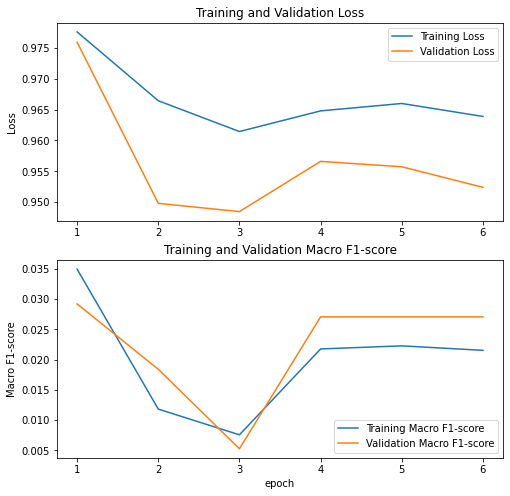

In [30]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)
#losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history_bce)

Role of macro soft-F1 loss
So far, we have trained two neural network models with same architecture.
The first one was optimizing directly for the macro F1-score, while the second one is more classic and optimized for the binary cross-entropy.
In both cases, the model trained will generate an independent probability score for each label when predicting the genre of a movie poster.
To create a final decision system, we need to pick a decision threshold between 0 and 1 for each label so as to transform each probability into a binary information. Usually the performance of the system depends on the choice of these decision thresholds.
So, let's examine how the system behaves on the validation set depending on the level where we set the threshold for each label.

Decision threshold
There is a function named perf_grid in the utils module that helps create the performance grid.
In the performance grid, thresholds increment from 0 to 1 by a step of 0.01 for each label.
For each threshold and for each label, we compute different measures (tp, fn, fp, precision, recall, f1-score).

In [21]:
def perf_grid(ds, target, label_names, model, n_thresh=100):
    """Computes the performance table containing target, label names,
    label frequencies, thresholds between 0 and 1, number of tp, fp, fn,
    precision, recall and f-score metrics for each label.
    
    Args:
        ds (tf.data.Datatset): contains the features array
        target (numpy array): target matrix of shape (BATCH_SIZE, N_LABELS)
        label_names (list of strings): column names in target matrix
        model (tensorflow keras model): model to use for prediction
        n_thresh (int) : number of thresholds to try
        
    Returns:
        grid (Pandas dataframe): performance table 
    """
    
    # Get predictions
    tf_batch = tokenizer(ds.tolist(), max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    y_hat_val = tf.nn.softmax(tf_outputs[0], axis=-1).numpy()   

#    y_hat_val = model.predict(ds)
    # Define target matrix
    y_val = target
    # Find label frequencies in the validation set
    label_freq = target.sum(axis=0)
    # Get label indexes
    label_index = [i for i in range(len(label_names))]
    # Define thresholds
    thresholds = np.linspace(0,1,n_thresh+1).astype(np.float32)
    
    # Compute all metrics for all labels
    ids, labels, freqs, tps, fps, fns, precisions, recalls, f1s = [], [], [], [], [], [], [], [], []
    for l in label_index:
        for thresh in thresholds:   
            ids.append(l)
            labels.append(label_names[l])
            freqs.append(round(label_freq[l]/len(y_val),2))
            y_hat = y_hat_val[:,l]
            y = y_val[:,l]
            y_pred = y_hat > thresh
            tp = np.count_nonzero(y_pred  * y)
            fp = np.count_nonzero(y_pred * (1-y))
            fn = np.count_nonzero((1-y_pred) * y)
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            
    # Create the performance dataframe
    grid = pd.DataFrame({
        'id':ids,
        'label':labels,
        'freq':freqs,
        'threshold':list(thresholds)*len(label_index),
        'tp':tps,
        'fp':fps,
        'fn':fns,
        'precision':precisions,
        'recall':recalls,
        'f1':f1s})
    
    grid = grid[['id', 'label', 'freq', 'threshold',
                 'tp', 'fn', 'fp', 'precision', 'recall', 'f1']]
    
    return grid


In [36]:
#(df_test[LABEL_COLUMNS]).values[5]
predictions.numpy()[10]

array([0.10652285, 0.23526458, 0.04302963, 0.03471209, 0.15347996,
       0.26974434, 0.04611369, 0.11113293], dtype=float32)

In [23]:
# Get all label names
label_names = LABEL_COLUMNS
# Performance table with the first model (macro soft-f1 loss)
grid = perf_grid(df_test[DATA_COLUMN], df_test[LABEL_COLUMNS].values, label_names, model)
# Performance table with the second model (binary cross-entropy loss)
grid_bce = perf_grid(df_test[DATA_COLUMN], df_test[LABEL_COLUMNS].values, label_names, model_bce)


In [39]:
grid_bce.head()

,id,label,freq,threshold,tp,fn,fp,precision,recall,f1
0,0,economic_labour_tension_direction_decrease,0.0,0.00,0,0,329,0.0,0.0,0.0
1,0,economic_labour_tension_direction_decrease,0.0,0.01,0,0,329,0.0,0.0,0.0
2,0,economic_labour_tension_direction_decrease,0.0,0.02,0,0,329,0.0,0.0,0.0
3,0,economic_labour_tension_direction_decrease,0.0,0.03,0,0,329,0.0,0.0,0.0
4,0,economic_labour_tension_direction_decrease,0.0,0.04,0,0,329,0.0,0.0,0.0


In [25]:
# Get the maximum F1-score for each label when using the second model and varying the threshold
max_perf = grid_bce.groupby(['id', 'label', 'freq'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
max_perf.rename(columns={'f1':'f1max_bce'}, inplace=True)
max_perf.style.background_gradient(subset=['freq', 'f1max_bce'], cmap=sns.light_palette("lightgreen", as_cmap=True))

,id,label,freq,f1max_bce
0,3,political_tension_direction_increase,0.060000,0.130031
1,5,service_related_tension_direction_increase,0.050000,0.094395
2,1,economic_labour_tension_direction_increase,0.050000,0.088496
3,7,community_insecurity_tension_direction_increase,0.020000,0.034602
4,4,service_related_tension_direction_decrease,0.010000,0.024390
5,0,economic_labour_tension_direction_decrease,0.000000,0.000000
6,2,political_tension_direction_decrease,0.000000,0.000000
7,6,community_insecurity_tension_direction_decrease,0.000000,0.000000


In [26]:
print("Correlation between label frequency and optimal F1 with bce: %.2f" %max_perf['freq'].corr(max_perf['f1max_bce']))


Correlation between label frequency and optimal F1 with bce: 0.99


In [27]:
top5 = max_perf.head(5)['id']

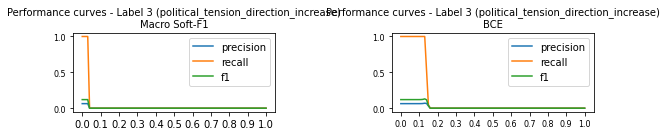

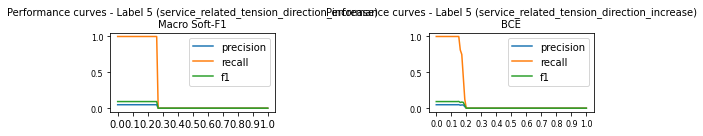

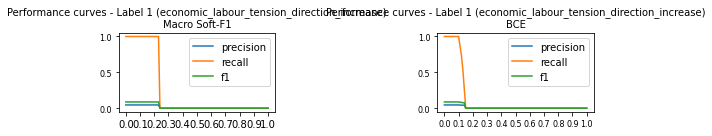

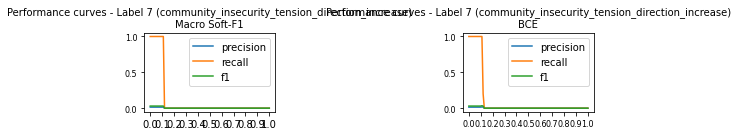

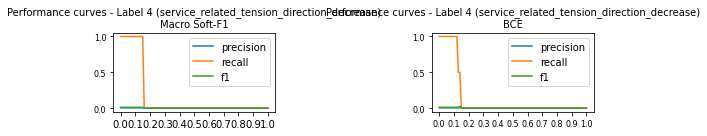

In [28]:
#style.use("default")
for l in top5:
    
    label_grid = grid.loc[grid['id']==l, ['precision','recall','f1']]
    label_grid = label_grid.reset_index().drop('index', axis=1)
    
    label_grid_bce = grid_bce.loc[grid_bce['id']==l, ['precision','recall','f1']]
    label_grid_bce = label_grid_bce.reset_index().drop('index', axis=1)
    
    plt.figure(figsize=(9,2))

    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=10)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    label_grid.plot(ax=ax)
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    label_grid_bce.plot(ax=ax)
    
    plt.tight_layout()
    plt.show()

In [29]:
# Predict on the validation set with both models
tf_batch = tokenizer(df_test[DATA_COLUMN].tolist(), max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
y_hat_val = tf.nn.softmax(tf_outputs[0], axis=-1)

tf_outputs_bce = model_bce(tf_batch)
y_hat_val_bce = tf.nn.softmax(tf_outputs_bce[0], axis=-1)


y_true = df_test[LABEL_COLUMNS].to_numpy()             
                     
LABELS = LABEL_COLUMNS


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


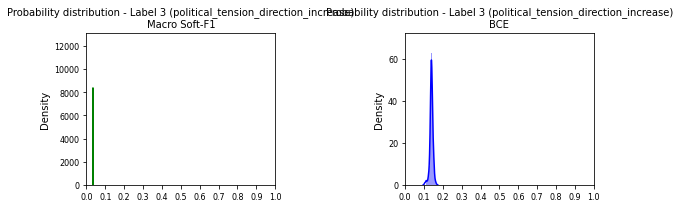

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


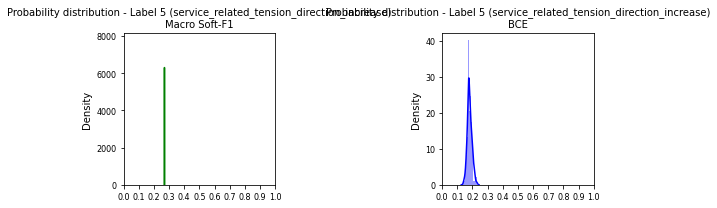

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


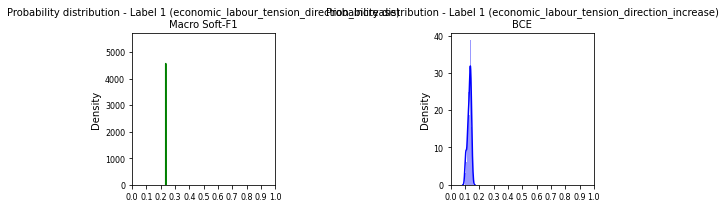

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


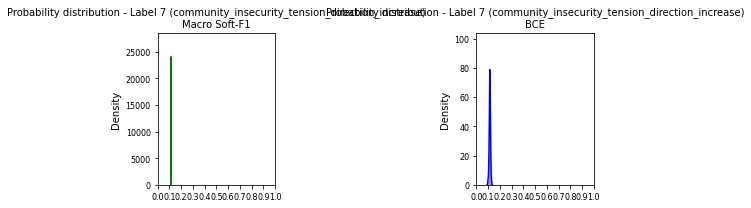

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


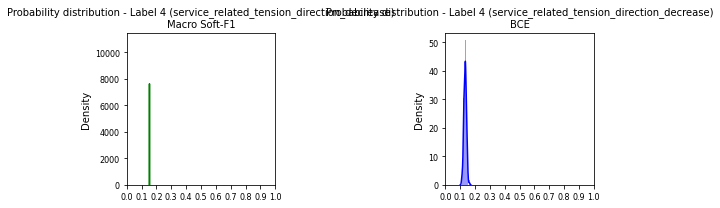

In [30]:
#style.use("default")
for l in top5:
        
    plt.figure(figsize=(9,3))
    
    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val[:,l], bins=30, kde=True, color="g")
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val_bce[:,l], bins=30, kde=True, color="b")
    
    plt.tight_layout()
    plt.show()

In [31]:
"""Batch prediction for validation data"""
tf_batch = tokenizer(df_test[DATA_COLUMN].tolist(), max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
predictions = tf.nn.softmax(tf_outputs[0], axis=-1)

y_true = df_test[LABEL_COLUMNS].to_numpy()             
                     
LABELS = LABEL_COLUMNS

#X_test = test["DATA_COLUMN"]
#predictions = model.predict(X_test, batch_size=1000)




In [43]:
my_threshold = DECISION_THRESHOLD

y_pred = []
for sample in predictions.numpy():
    y_pred.append([1 if i >= my_threshold else 0 for i in sample ])

y_pred = np.array(y_pred)
#y_pred[8]
#predictions.numpy()[8]

#df_predictions = pd.DataFrame(predictions.numpy())

#df_predictions
#y_true[8]
confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)

In [44]:
"""Classification report"""
print(classification_report(y_true, y_pred,target_names=LABEL_COLUMNS))

                                                 precision    recall  f1-score   support

     economic_labour_tension_direction_decrease       0.00      0.00      0.00         0
     economic_labour_tension_direction_increase       0.05      1.00      0.09        15
           political_tension_direction_decrease       0.00      0.00      0.00         0
           political_tension_direction_increase       0.00      0.00      0.00        21
     service_related_tension_direction_decrease       0.01      1.00      0.01         2
     service_related_tension_direction_increase       0.05      1.00      0.09        16
community_insecurity_tension_direction_decrease       0.00      0.00      0.00         0
community_insecurity_tension_direction_increase       0.02      1.00      0.03         5

                                      micro avg       0.02      0.64      0.04        59
                                      macro avg       0.01      0.50      0.03        59
                   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

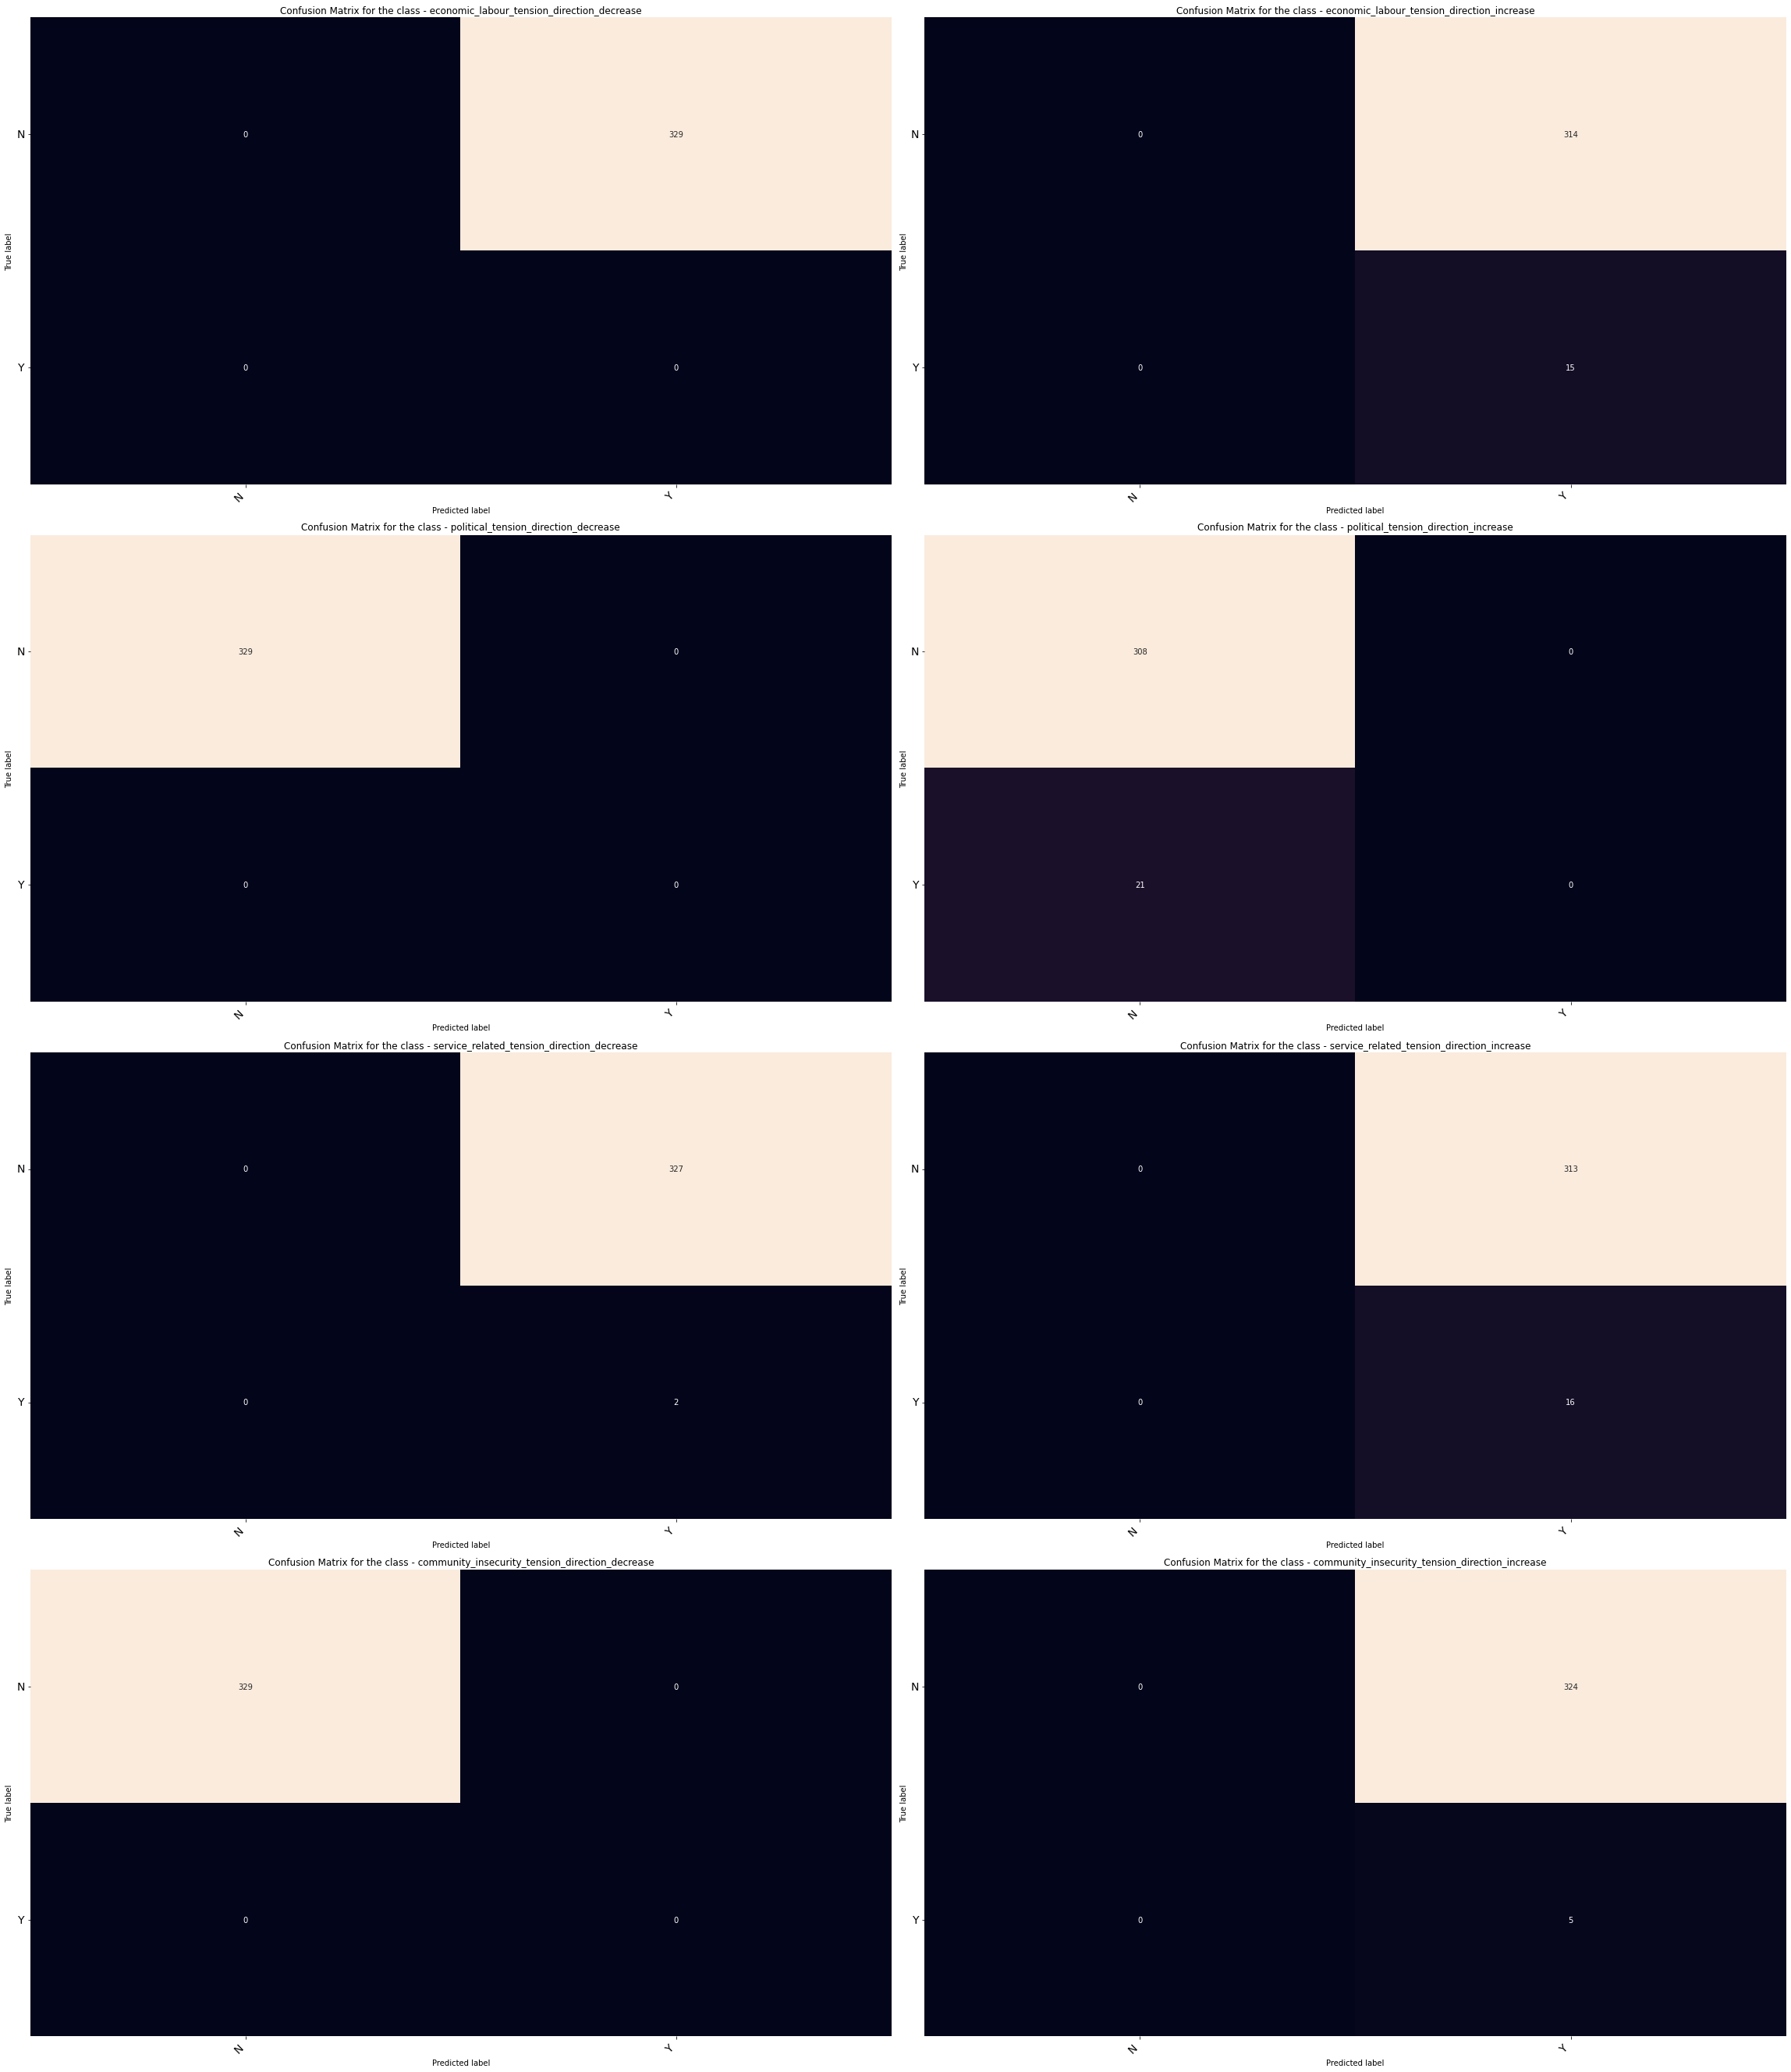

In [46]:
"""Visualization of multilabel confusion matrix"""

fig, ax = plt.subplots(4, 2, figsize=(32, 37))
    
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, LABEL_COLUMNS):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

In [ ]:
"""Some auxiliary expressions to get an idea about the data structure"""
#df_train
#list(train_data.batch(1, drop_remainder=True))
#train_input_examples
#train_input_examples[1]

'Some auxiliary expressions to get an idea about the data structure'

## Baseline model using the annotations from the training data

This is quite horribly written and has a double loop in the predict which makes it slow so 
should probably be cleaned up etc

In [ ]:
df_annotations = pd.merge(train_df, df_appendix, on="object_id")

In [ ]:
TENSIONS = [
    "economic_labour_tension",
    "political_tension",
    "service_related_tension",
    "community_insecurity_tension",
]

all_feats = []
for tension in TENSIONS:
    feats = df_annotations[~df_annotations[f"{tension}_features"].isnull()][f"{tension}_features"]
    if len(feats) > 0:
        feats = pd.DataFrame({"feature": feats.str.split(",").explode()})
        feats["tension"] = tension
        all_feats.append(feats)
feats = pd.concat(all_feats, ignore_index=True, axis=0)
feats = {f["feature"]: f["tension"] for _, f in feats.iterrows()}


class Baseline(BaseEstimator, ClassifierMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        predictions = []
        for _, row in X.iterrows():
            out = {f"is_{t}": False for t in TENSIONS}
            for feat, tension in self.features.items():
                if feat in row["text"]:
                    out[f"is_{tension}"] = True
            predictions.append(out)
        return pd.DataFrame(predictions)[COL_ORDER].values

In [ ]:
def test(model, df):
    preds = model.predict(df)
    return metrics.f1_score(df[COL_ORDER].values, preds, average="macro")

In [ ]:
model = Baseline(feats)

test(model, train_df), test(model, test_df)

(0.08444991747911457, 0.0)

## Quick and dirty Random Forest classifier using the topics

In [ ]:
class CategoricalColumns(BaseEstimator, TransformerMixin):
    """CategoricalColumns is a quick and dirty One Hot Encoder transformer for the topics column."""
    def fit(self, df, y=None):
        topics = self._to_array(df["topics"])
        columns = topics.explode().unique()
        self.columns = [c.strip() for c in columns]
        return self
        
    def transform(self, df):
        out = {}
        for col in self.columns:
            out[col] = df["topics"].str.contains(col).astype(int)
        return pd.DataFrame(out)
        
    def _to_array(self, series):
        """Clean up a series to """
        remove = ["[", "]", "'"]
        for char in remove:
            series = series.str.replace(char, "", regex=False)
        return series.str.split(",")

In [ ]:
#CategoricalColumns returns this one-hot encoding.
CategoricalColumns().fit_transform(train_df)

,other,lebanese army/security forces,religious figure,covid / vaccination,beirut,economic collapse,education,foreign countries,lebanese revolution,north lebanon,...,occupied palestine,false news,call for protest,aid,external affairs/diplomacy,offensive language,international organizations / un,south lebanon,lebanese judiciary,asad regime
1409,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
963,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1450,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1174,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
452,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1152,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1365,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
forest = RandomForestClassifier(random_state=2021, class_weight="balanced")
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

model = Pipeline(
    [
        ("categories", CategoricalColumns()),
        ("random_forest", multi_target_forest)
    ]
)

model = model.fit(train_df, train_df[COL_ORDER].values)

test(model, train_df), test(model, test_df)

(0.23948309102198564, 0.20484195032733407)